# Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Описание проекта: Проект направлен на разработку модели обучения с учителем, которая интернет-магазину «В один клик» удерживать активность постоянных клиентов. Сделать это можно с помощью  персонализированных предложений.

Цель разработки: на основе анализа данных и бизнес-моделирования разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Ход исследования: Для достижения цели необходимо выполнить следующие шаги:

• Сбор данных: Получить доступ к данным интернет-магазина «В один клик».

• Предобработка данных: Очистка данных от выбросов и ошибок, пропусков и дубликатов.

• Анализ данных:

* Провести исследовательский  анализ всех признаков.

* Отобрать клиентов с покупательской активностью не менее трёх месяцев.

* Сделать выводы о данных.


• Объединить таблицы, сделать отдельный столбец для каждого периода по выручке.

• Провести корреляционный анализ. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

• Использовать пайплайны.Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Выбрать лучшую.

• Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

• Выполнить сегментацию покупателей. Использовать результаты моделирования и данные о прибыльности покупателей.

• Сделайте общий вывод.

In [1]:
import pandas as pd
import numpy as np
!!pip install matplotlib==3.5 -q
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-learn==1.1.3 -q
!pip install phik -q
!pip install shap -q
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    OrdinalEncoder,
    MinMaxScaler, 
    LabelEncoder
)
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm


## Загрузка данных

Загрузим данные в датафрейм market_file, market_money, market_time и money.

In [2]:
market_file = pd.read_csv('/datasets/market_file.csv')
print(market_file.info())
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


На первый взгляд в глаза бросается столбец "Тип сервиса", где слово "стандартт" написано с двумя т
По выведенной информации можно заметить, что пропуски отсутсвуют, а тип данных указан корректно.

In [3]:
market_money = pd.read_csv('/datasets/market_money.csv')
print(market_money.info())
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Пропуски в данном датасете отсутствуют, типы указаны корректно. Но в столбце "Период" наблюдаются неявные дубликаты.

In [4]:
market_time = pd.read_csv('/datasets/market_time.csv')
print(market_time.info())
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Пропуски в данном датасете отсутствуют, типы указаны корректно. Но в столбце "Период" наблюдаются неявные дубликаты.

In [5]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')
print(money.info())
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Пропуски в данном датасете отсутствуют, типы указаны корректно. 

Данные в датасетах соответствуют заявленны данным.

## Предобработка данных

Исправим неявные дубликаты обнаруженные в 1 пункте и проверим остальные данные.

Датасет market_file.

In [6]:
market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [7]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({'стандартт': 'стандарт'})
print(market_file['Тип сервиса'].unique())

['премиум' 'стандарт']


Переименуем некоторые столбцы.

In [8]:
market_file = market_file.rename(columns={'Покупательская активность': 'Покуп_актив', 'Тип сервиса': 'Тип_сервиса', 'Разрешить сообщать': 'Разр_сообщать'})
market_file.head()

,id,Покуп_актив,Тип_сервиса,Разр_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Датасет market_money.

In [9]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Датасет market_time.

In [10]:
market_time = market_time.rename(columns={'минут': 'Минут'})
market_time.head()

,id,Период,Минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [12]:
market_time['Период'] = market_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
print(market_time['Период'].unique())

['текущий_месяц' 'предыдущий_месяц']


Посчитаем дубликаты в каждой таблице.

Датасет market_file.

In [13]:
# поиск дубликатов
duplicates = market_file.duplicated()

# подсчет дубликатов
num_duplicates = duplicates.sum()
print(num_duplicates)

0


Датасет market_money.

In [14]:
duplicates = market_money.duplicated()
num_duplicates = duplicates.sum()
print(f'Дубликатов - {num_duplicates}')

Дубликатов - 0


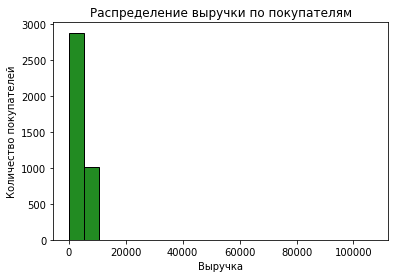

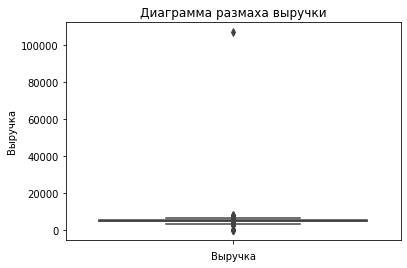

In [15]:
plt.hist(market_money['Выручка'], bins=20, color='ForestGreen', edgecolor='black')
plt.xlabel('Выручка')
plt.ylabel('Количество покупателей')
plt.title('Распределение выручки по покупателям')
plt.show()

sns.boxplot(y='Выручка', data=market_money, color='MediumVioletRed')
plt.xlabel('Выручка')
plt.title('Диаграмма размаха выручки')
plt.show()

Наблюдается выброс.

In [16]:
market_money.query('Выручка > 20000')

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Заполним данный выброс медианным значением.

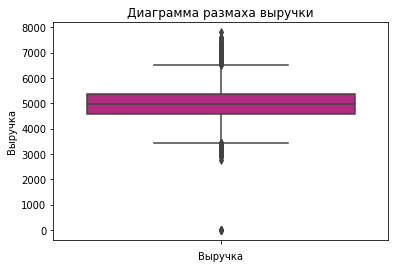

In [17]:
median_value = market_money.query("Выручка < 20000")["Выручка"].median()
market_money.loc[market_money["Выручка"] > 20000, "Выручка"] = median_value
sns.boxplot(y='Выручка', data=market_money, color='MediumVioletRed')
plt.xlabel('Выручка')
plt.title('Диаграмма размаха выручки')
plt.show()

In [18]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Выручка распределена нормально.

Датасет market_time.

In [19]:
duplicates = market_time.duplicated()
num_duplicates = duplicates.sum()
print(f'Дубликатов - {num_duplicates}')

Дубликатов - 0


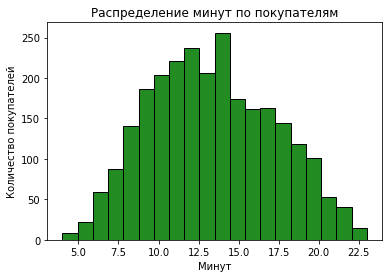

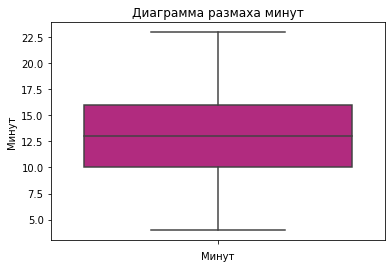

In [20]:
plt.hist(market_time['Минут'], bins=20, color='ForestGreen', edgecolor='black')
plt.xlabel('Минут')
plt.ylabel('Количество покупателей')
plt.title('Распределение минут по покупателям')
plt.show()

sns.boxplot(y='Минут', data=market_time, color='MediumVioletRed')
plt.xlabel('Минут')
plt.title('Диаграмма размаха минут')
plt.show()

Распределено нормально.

Датасет money.

In [21]:
duplicates = money.duplicated()
num_duplicates = duplicates.sum()
print(f'Дубликатов - {num_duplicates}')

Дубликатов - 0


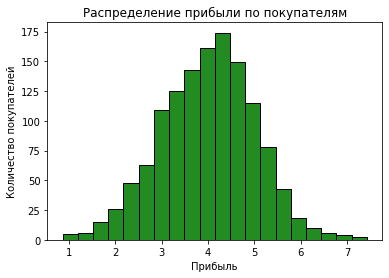

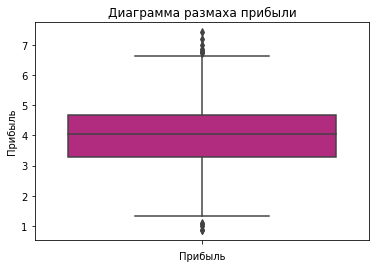

In [22]:
plt.hist(money['Прибыль'], bins=20, color='ForestGreen', edgecolor='black')
plt.xlabel('Прибыль')
plt.ylabel('Количество покупателей')
plt.title('Распределение прибыли по покупателям')
plt.show()

sns.boxplot(y='Прибыль', data=money, color='MediumVioletRed')
plt.xlabel('Прибыль')
plt.title('Диаграмма размаха прибыли')
plt.show()

Распределено нормально.

## Исследовательский анализ данных

Датасет market_file.

In [23]:
market_file.columns

Index(['id', 'Покуп_актив', 'Тип_сервиса', 'Разр_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

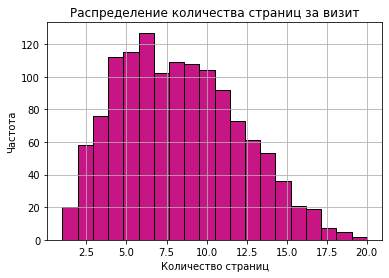

In [24]:
filtered_market_file = market_file[market_file['Длительность'] >= 90]
# Строим гистограмму по числу страниц за визит
plt.hist(filtered_market_file['Страниц_за_визит'], bins=20, color='MediumVioletRed', edgecolor='black')
plt.title('Распределение количества страниц за визит')
plt.xlabel('Количество страниц')
plt.ylabel('Частота')
plt.grid(True)

# Показываем график
plt.show()

Датасет market_money.

Построим гистограмму, отражающую распределение выручки за прошлый и текущий месяц.

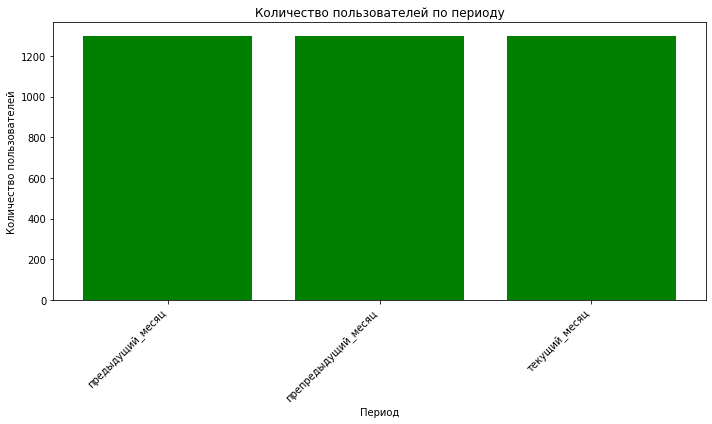

In [25]:
market_money_filtr = market_money.groupby('Период')['Выручка'].count()

plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
plt.bar(market_money_filtr.index, market_money_filtr.values, color='Green')
plt.xlabel("Период")
plt.ylabel("Количество пользователей")
plt.title("Количество пользователей по периоду")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()


По гистограмме видно, что сумма выручки значительно снизилась по сравнению с предыдущим месяцем.

In [26]:
market_money.query('Выручка == 0')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [27]:
ids_to_remove = [215348, 215357, 215359]

market_time = market_time[~market_time['id'].isin(ids_to_remove)]
market_money = market_money[~market_money['id'].isin(ids_to_remove)]
market_file = market_file[~market_file['id'].isin(ids_to_remove)]
money = money[~money['id'].isin(ids_to_remove)]


Датасет market_time.

Построим гистограмму, отражающую распределение минут за прошлый и текущий месяц.

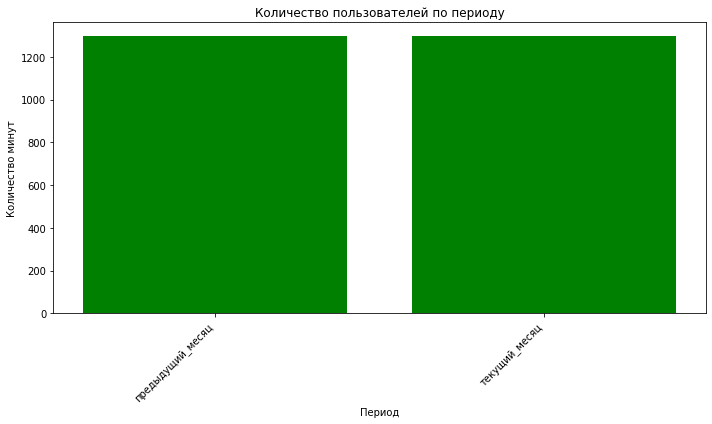

In [28]:
market_time_filtr = market_time.groupby('Период')['Минут'].count()

plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
plt.bar(market_time_filtr.index, market_time_filtr.values, color='Green')
plt.xlabel("Период")
plt.ylabel("Количество минут")
plt.title("Количество пользователей по периоду")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

По гистограмме видно, что суммарное время посещения сайта за предыдущий и текущий месяц не изменилось.

In [29]:
print('market_file' ,market_file.shape[0])
print('market_money', market_money.shape[0])
print('time', market_time.shape[0])
print('money', money.shape[0])

market_file 1297
market_money 3891
time 2594
money 1297


## Объединение таблиц

Объединим таблицы market_file, market_money и market_time.

In [30]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   Период   3891 non-null   object 
 2   Выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


In [31]:
market_money.head(10)

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4
10,215351,предыдущий_месяц,6158.0
11,215351,препредыдущий_месяц,4793.0
12,215352,предыдущий_месяц,5807.5


In [32]:
market_money_pivoted = market_money.pivot_table(index='id', columns='Период', values='Выручка').reset_index()
market_money_pivoted.columns = ['id', 'выручка_за_предыдущий_месяц','выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц']
display(market_money_pivoted)


,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6


In [33]:
market_money_pivoted.isna().sum()

id                                0
выручка_за_предыдущий_месяц       0
выручка_за_препредыдущий_месяц    0
выручка_за_текущий_месяц          0
dtype: int64

In [34]:
missing_rows = market_money_pivoted[market_money_pivoted['выручка_за_текущий_месяц'].isna()]
missing_rows

,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц


In [35]:
mask = market_money_pivoted['id'] == 215380
market_money_pivoted.loc[mask, 'выручка_за_текущий_месяц'] = market_money_pivoted.loc[mask, 'выручка_за_текущий_месяц'].fillna(
    (market_money_pivoted.loc[mask, 'выручка_за_препредыдущий_месяц'] + market_money_pivoted.loc[mask, 'выручка_за_предыдущий_месяц']) / 2
)
market_money_pivoted.isna().sum()

id                                0
выручка_за_предыдущий_месяц       0
выручка_за_препредыдущий_месяц    0
выручка_за_текущий_месяц          0
dtype: int64

In [36]:
market_time.head(10)

,id,Период,Минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдущий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдущий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдущий_месяц,8
10,215353,предыдущий_месяц,10
11,215353,текущий_месяц,10


In [37]:
market_time_pivoted = market_time.pivot_table(index='id', columns='Период', values='Минут').reset_index()
market_time_pivoted.columns = ['id', 'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']
display(market_time_pivoted)


,id,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10
...,...,...,...
1292,216643,14,7
1293,216644,12,11
1294,216645,12,18
1295,216646,18,7


In [38]:
df_merged = pd.merge(
    market_money_pivoted,
    market_time_pivoted,
    on=['id'],
    how='outer'
)

market_final = pd.merge(
    df_merged,
    market_file,
    on='id',
    how='outer'
)
market_final

,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Покуп_актив,Тип_сервиса,Разр_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
1,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
2,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
3,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
4,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7,14,7,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1293,216644,4729.0,5299.0,5353.0,12,11,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1294,216645,5160.0,5334.0,5139.2,12,18,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1295,216646,4923.0,4725.0,5224.6,18,7,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [39]:
market_final.isna().sum()

id                                     0
выручка_за_предыдущий_месяц            0
выручка_за_препредыдущий_месяц         0
выручка_за_текущий_месяц               0
минут_за_предыдущий_месяц              0
минут_за_текущий_месяц                 0
Покуп_актив                            0
Тип_сервиса                            0
Разр_сообщать                          0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

В таблице market_money выброс заполнила медианным значением и удилила только информацию о трех пользователях.
Финальную таблицу проверила на пропуски, они отсутсвуют.

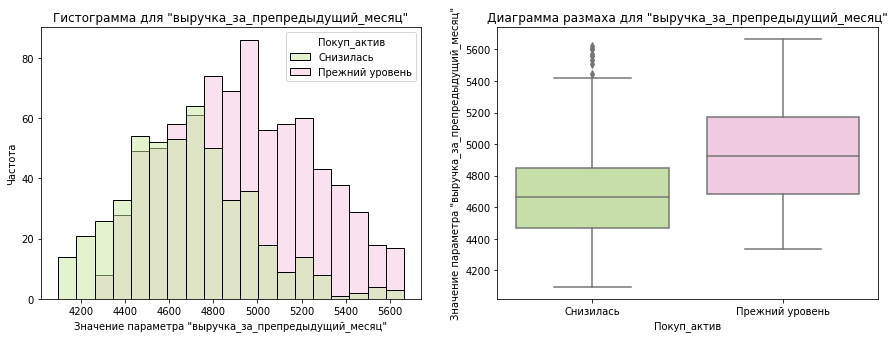

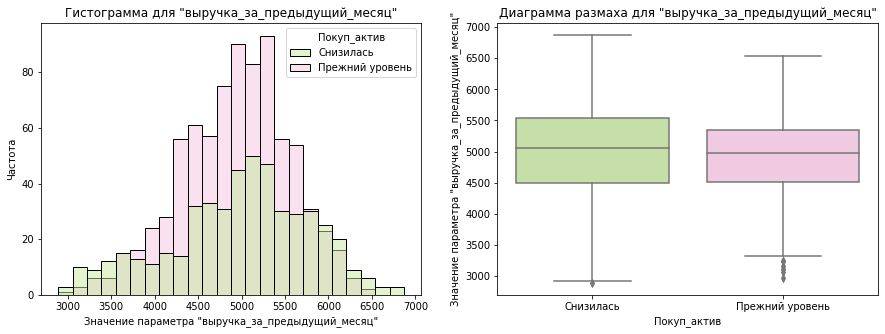

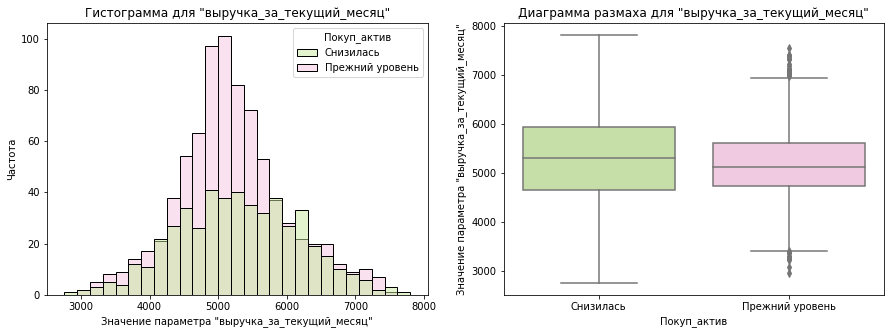

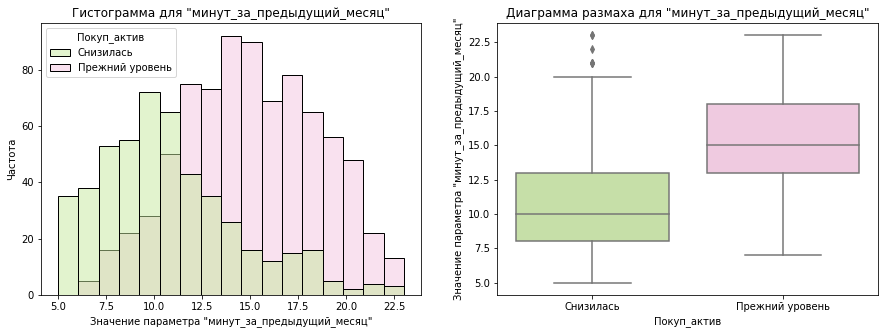

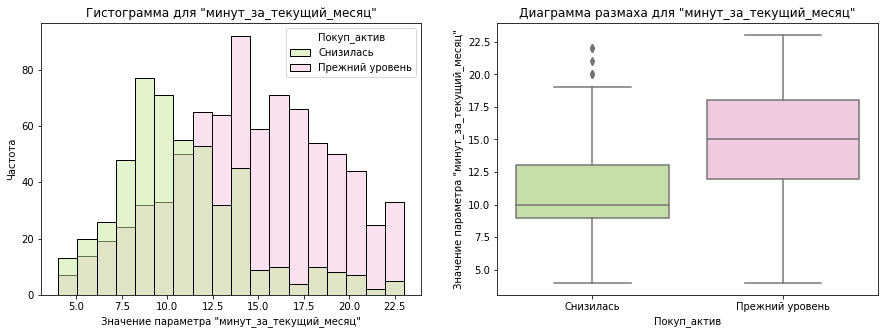

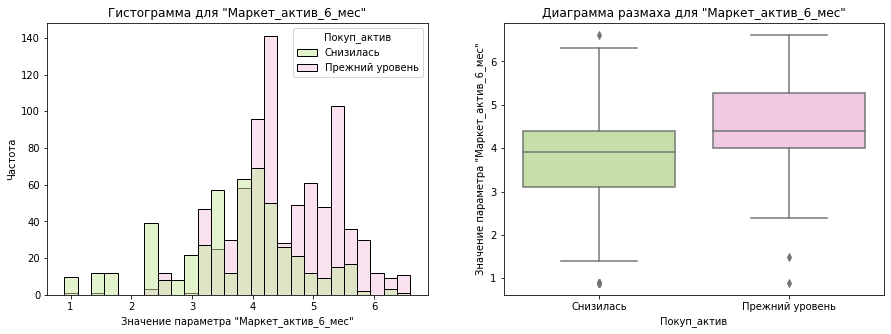

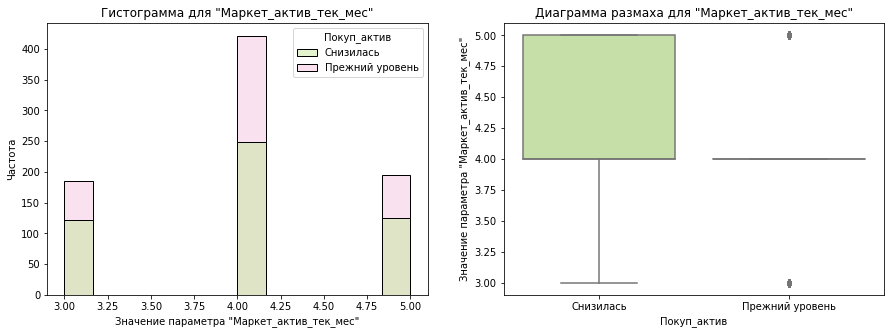

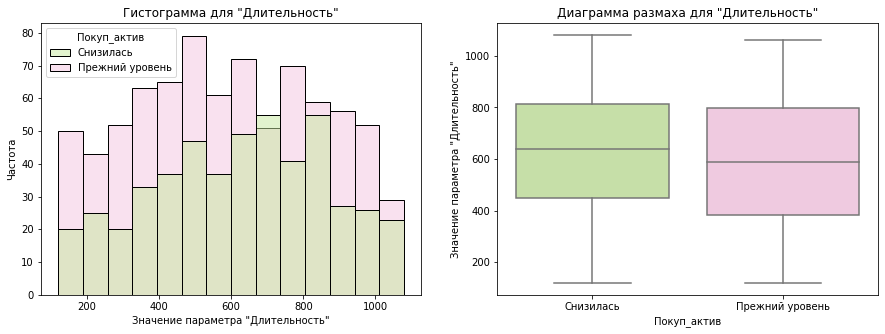

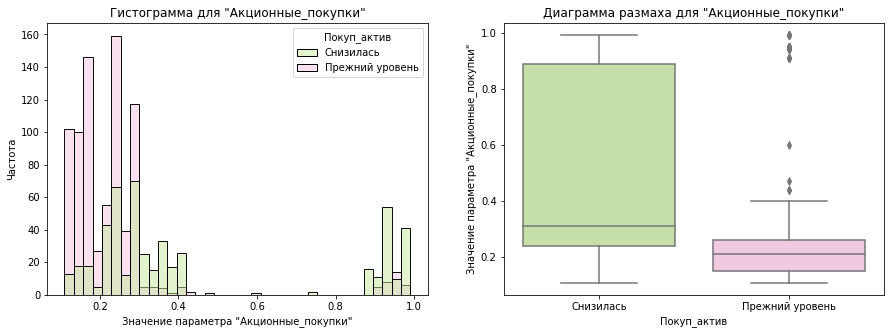

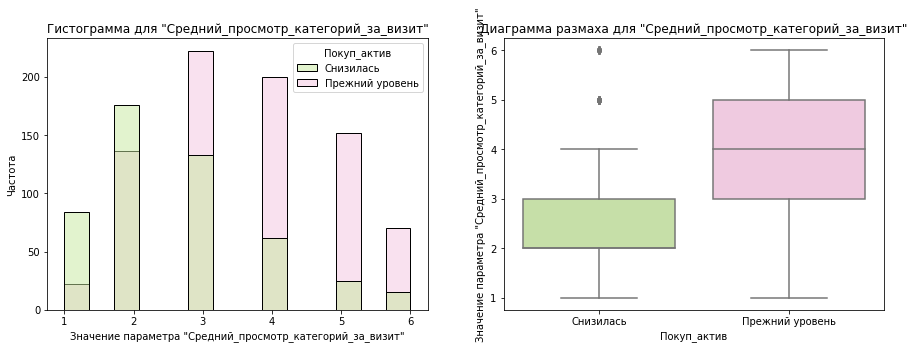

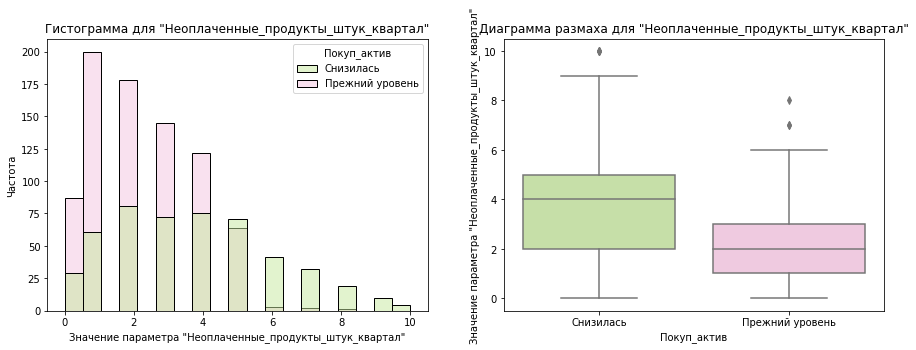

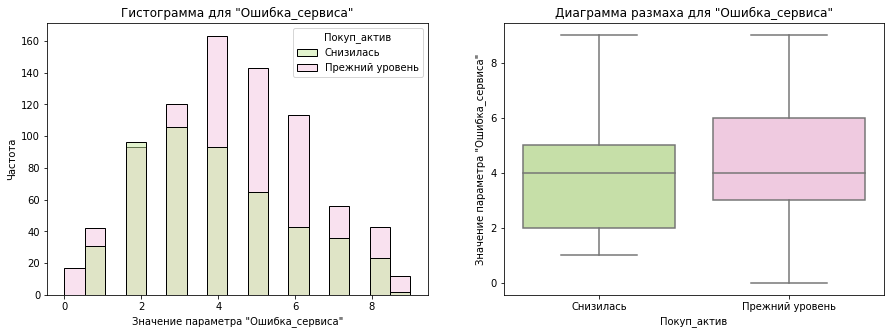

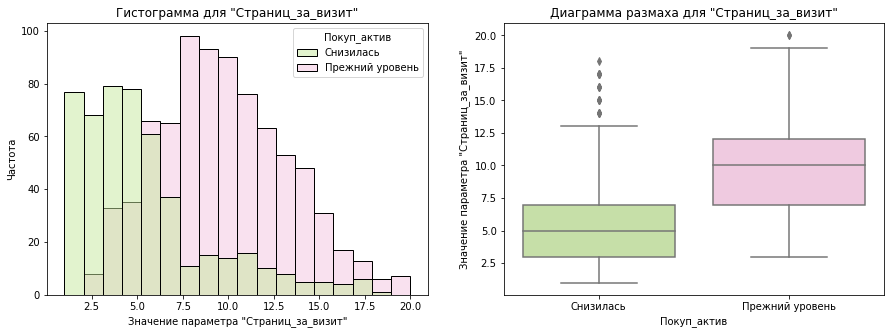

In [40]:
num_col = ['выручка_за_препредыдущий_месяц',
           'выручка_за_предыдущий_месяц',
           'выручка_за_текущий_месяц',
           'минут_за_предыдущий_месяц',
           'минут_за_текущий_месяц',
           'Маркет_актив_6_мес',
           'Маркет_актив_тек_мес',
           'Длительность',
           'Акционные_покупки',
           'Средний_просмотр_категорий_за_визит',
           'Неоплаченные_продукты_штук_квартал',
           'Ошибка_сервиса',
           'Страниц_за_визит'] 

for name in num_col:
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма для "{name}"')
    sns.histplot(data=market_final, x=name, hue='Покуп_актив', palette='PiYG_r')
    plt.xlabel(f'Значение параметра "{name}"')
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха для "{name}"')
    sns.boxplot(x='Покуп_актив', y=name, data=market_final, palette='PiYG_r');
    plt.ylabel(f'Значение параметра "{name}"')

Средние значения признаков Средний_просмотр_категорий_за_визит, Страниц_за_визит, выручка_за_предыдущий_месяц, минут_за_предыдущий_месяц и минут_за_текущий_месяц ниже у покупателей со сниженной активностью по сравнению с покупателями, сохранившими прежний уровень активности.

В то же время клиенты с меньшим количеством акционных покупок склонны снижать активность. Наличие выбросов в группе "Снизилась" может свидетельствовать о клиентах, которые совершали экстремально много или мало акционных покупок, но всё равно снизили активность.

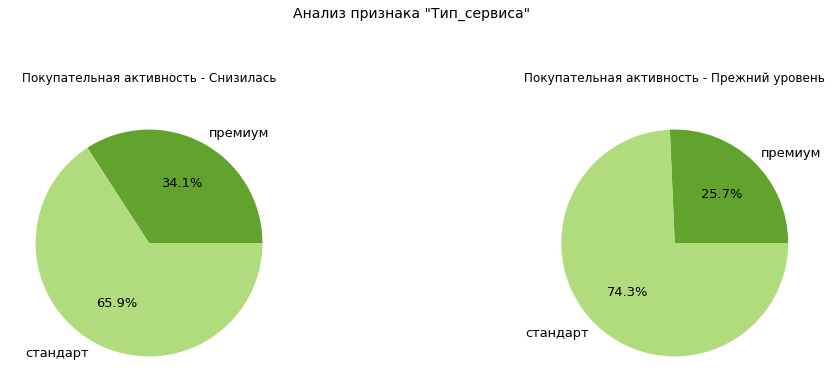

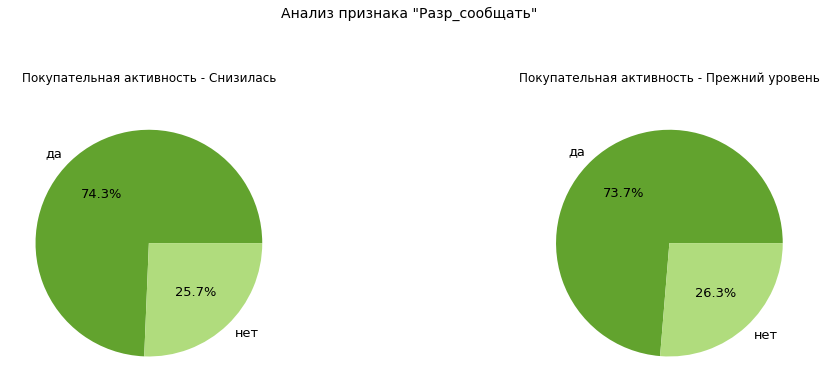

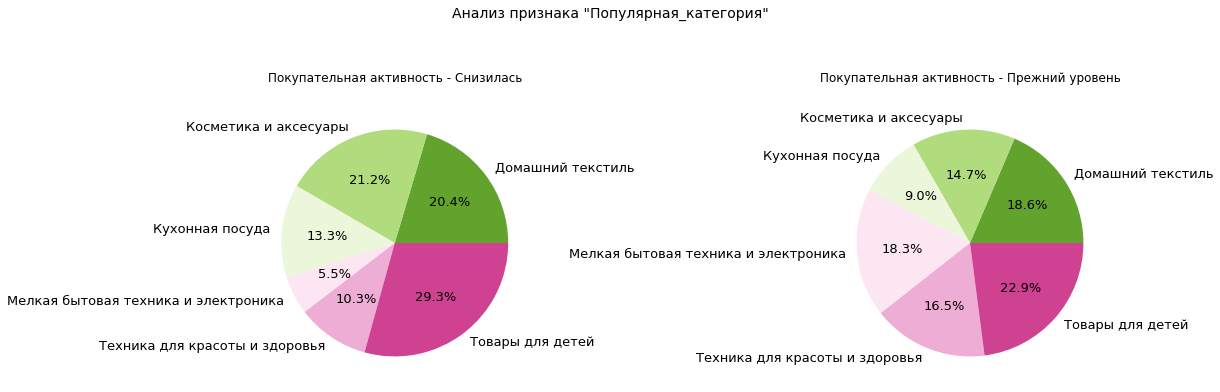

In [41]:
cat_col = ['Тип_сервиса', 'Разр_сообщать', 'Популярная_категория']
palette = sns.color_palette('PiYG_r')
plot_params = {'autopct': '%1.1f%%'}

for name in cat_col:
    grouped = market_final.groupby([name, 'Покуп_актив'])['id'].count().unstack(fill_value=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))  
    fig.subplots_adjust(wspace=0.4)  
    fig.suptitle(f'Анализ признака "{name}"', y=1.08, fontsize=14) 
    
    plots = [
        ('Снизилась', 'Покуп_актив == "Снизилась"'),
        ('Прежний уровень', 'Покуп_актив != "Снизилась"')
    ]
    
    for ax, (title, condition) in zip(axes, plots):
        data = grouped[title] if title in grouped.columns else grouped.sum(axis=1)*0
        labels = data.index
        
        ax.set_title(f'Покупательная активность - {title}', pad=20, fontsize=12)  
        if data.sum() > 0:
            ax.pie(data, 
                   labels=labels, 
                   colors=palette, 
                   textprops={'fontsize': 13}, 
                   **plot_params)
            ax.set_xlabel('')  
            ax.set_ylabel('')
        else:
            ax.text(0.5, 0.5, 'Нет данных', ha='center', va='center', fontsize=15)
    
    plt.tight_layout()

Категориальные признаки почти одинаковые что для покупателей с низкой покупательской активностью, что с высокой.

## Корреляционный анализ

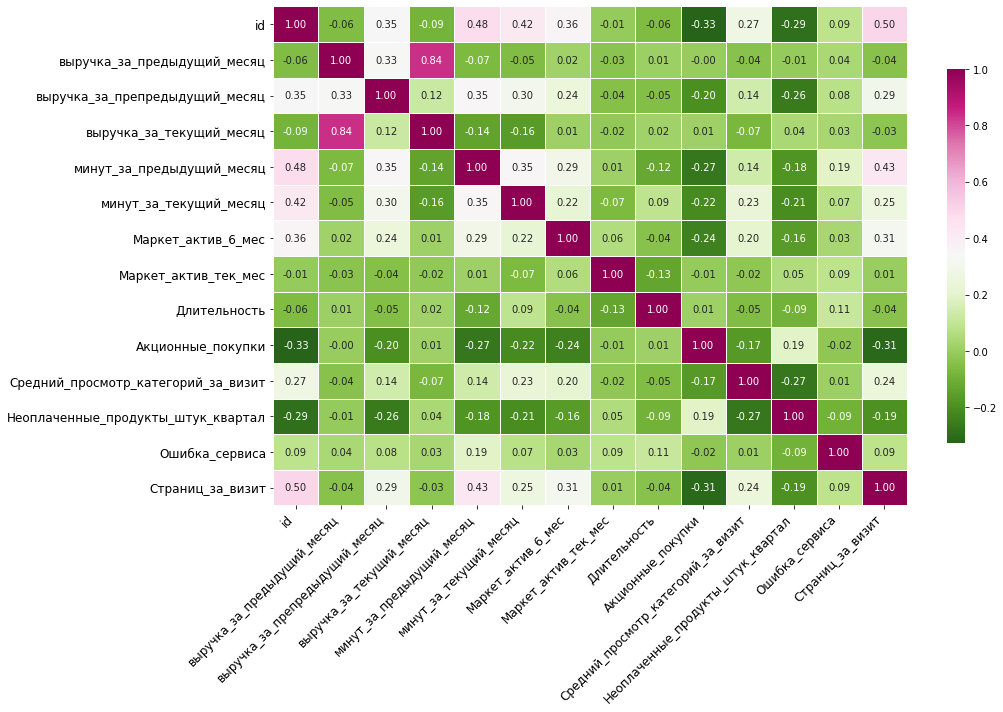

In [42]:
quantitative_features = market_final.select_dtypes(include=[np.number]).columns
df_quant = market_final[quantitative_features]
correlation_matrix = df_quant.corr()
#correlation_matrix = correlation_matrix.drop(index=['id'], columns=['id'])

plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='PiYG_r', linewidths=.5, cbar_kws={'shrink': 0.75})
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Наивысшая корреляция наблюдается между "выручка_за_текущий_месяц" и "выручка_за_предыдущий_месяц".
А также страниц_за_визит имеет зависимость от минут_за_предыдущий_месяц, что вполне логично.

In [43]:
correlation_matrix.style.background_gradient('PiYG_r')

,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,1.000000,-0.055704,0.347172,-0.086202,0.480114,0.418908,0.355921,-0.006203,-0.060385,-0.326324,0.271406,-0.293157,0.085214,0.499057
выручка_за_предыдущий_месяц,-0.055704,1.000000,0.328247,0.837812,-0.065080,-0.052204,0.016442,-0.033834,0.010120,-0.001828,-0.039673,-0.005893,0.039707,-0.040131
выручка_за_препредыдущий_месяц,0.347172,0.328247,1.000000,0.121486,0.347279,0.299687,0.241783,-0.042649,-0.050222,-0.200848,0.140738,-0.262823,0.076182,0.292719
выручка_за_текущий_месяц,-0.086202,0.837812,0.121486,1.000000,-0.138991,-0.162055,0.013724,-0.016670,0.015979,0.014202,-0.074062,0.038338,0.031718,-0.029178
минут_за_предыдущий_месяц,0.480114,-0.065080,0.347279,-0.138991,1.000000,0.349399,0.288170,0.011086,-0.122151,-0.271253,0.135454,-0.182694,0.187261,0.425325
минут_за_текущий_месяц,0.418908,-0.052204,0.299687,-0.162055,0.349399,1.000000,0.221858,-0.066598,0.092506,-0.217316,0.225631,-0.206926,0.074364,0.254452
Маркет_актив_6_мес,0.355921,0.016442,0.241783,0.013724,0.288170,0.221858,1.000000,0.058556,-0.039157,-0.242752,0.203090,-0.164073,0.034421,0.314881
Маркет_актив_тек_мес,-0.006203,-0.033834,-0.042649,-0.016670,0.011086,-0.066598,0.058556,1.000000,-0.134009,-0.005580,-0.023904,0.054997,0.087952,0.005229
Длительность,-0.060385,0.010120,-0.050222,0.015979,-0.122151,0.092506,-0.039157,-0.134009,1.000000,0.012158,-0.054612,-0.092609,0.112254,-0.039542
Акционные_покупки,-0.326324,-0.001828,-0.200848,0.014202,-0.271253,-0.217316,-0.242752,-0.005580,0.012158,1.000000,-0.170592,0.190992,-0.024746,-0.307003


Мультиколлинеарность наблюдается при значениях более 0.8 у "выручка_за_текущий_месяц" и "выручка_за_предыдущий_месяц". 
Поэтому создадим новый столбец выручка_пред_тек, котоорый будет объединять в себе выручка_за_предыдущий_месяц и выручка_за_текущий_месяц.

In [44]:
market_final['выручка_пред_тек'] = market_final['выручка_за_предыдущий_месяц'] + market_final['выручка_за_текущий_месяц']
quantitative_features = market_final.select_dtypes(include=[np.number]).columns
df_quant = market_final[quantitative_features]
correlation_matrix = df_quant.corr()
correlation_matrix.style.background_gradient('PiYG_r')

,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_тек
id,1.000000,-0.055704,0.347172,-0.086202,0.480114,0.418908,0.355921,-0.006203,-0.060385,-0.326324,0.271406,-0.293157,0.085214,0.499057,-0.075369
выручка_за_предыдущий_месяц,-0.055704,1.000000,0.328247,0.837812,-0.065080,-0.052204,0.016442,-0.033834,0.010120,-0.001828,-0.039673,-0.005893,0.039707,-0.040131,0.950964
выручка_за_препредыдущий_месяц,0.347172,0.328247,1.000000,0.121486,0.347279,0.299687,0.241783,-0.042649,-0.050222,-0.200848,0.140738,-0.262823,0.076182,0.292719,0.225176
выручка_за_текущий_месяц,-0.086202,0.837812,0.121486,1.000000,-0.138991,-0.162055,0.013724,-0.016670,0.015979,0.014202,-0.074062,0.038338,0.031718,-0.029178,0.965595
минут_за_предыдущий_месяц,0.480114,-0.065080,0.347279,-0.138991,1.000000,0.349399,0.288170,0.011086,-0.122151,-0.271253,0.135454,-0.182694,0.187261,0.425325,-0.109741
минут_за_текущий_месяц,0.418908,-0.052204,0.299687,-0.162055,0.349399,1.000000,0.221858,-0.066598,0.092506,-0.217316,0.225631,-0.206926,0.074364,0.254452,-0.116674
Маркет_актив_6_мес,0.355921,0.016442,0.241783,0.013724,0.288170,0.221858,1.000000,0.058556,-0.039157,-0.242752,0.203090,-0.164073,0.034421,0.314881,0.015607
Маркет_актив_тек_мес,-0.006203,-0.033834,-0.042649,-0.016670,0.011086,-0.066598,0.058556,1.000000,-0.134009,-0.005580,-0.023904,0.054997,0.087952,0.005229,-0.025560
Длительность,-0.060385,0.010120,-0.050222,0.015979,-0.122151,0.092506,-0.039157,-0.134009,1.000000,0.012158,-0.054612,-0.092609,0.112254,-0.039542,0.013873
Акционные_покупки,-0.326324,-0.001828,-0.200848,0.014202,-0.271253,-0.217316,-0.242752,-0.005580,0.012158,1.000000,-0.170592,0.190992,-0.024746,-0.307003,0.007175


Теперь высокая коллериарность наблюдается у выручка_пред_тек только с выручка_за_предыдущий_месяц и выручка_за_текущий_месяц из которых он образован.
Избавились от мультиколлинеарности.

In [45]:
market_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   выручка_за_предыдущий_месяц          1297 non-null   float64
 2   выручка_за_препредыдущий_месяц       1297 non-null   float64
 3   выручка_за_текущий_месяц             1297 non-null   float64
 4   минут_за_предыдущий_месяц            1297 non-null   int64  
 5   минут_за_текущий_месяц               1297 non-null   int64  
 6   Покуп_актив                          1297 non-null   object 
 7   Тип_сервиса                          1297 non-null   object 
 8   Разр_сообщать                        1297 non-null   object 
 9   Маркет_актив_6_мес                   1297 non-null   float64
 10  Маркет_актив_тек_мес                 1297 non-null   int64  
 11  Длительность                  

In [46]:
market_final['выручка_пред_тек'].isnull().sum()

0

In [47]:
median_value = market_final['выручка_пред_тек'].median()
market_final['выручка_пред_тек'].fillna(median_value, inplace=True)
market_final['выручка_пред_тек'].isnull().sum()

0

## Использование пайплайнов

In [48]:
market_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   выручка_за_предыдущий_месяц          1297 non-null   float64
 2   выручка_за_препредыдущий_месяц       1297 non-null   float64
 3   выручка_за_текущий_месяц             1297 non-null   float64
 4   минут_за_предыдущий_месяц            1297 non-null   int64  
 5   минут_за_текущий_месяц               1297 non-null   int64  
 6   Покуп_актив                          1297 non-null   object 
 7   Тип_сервиса                          1297 non-null   object 
 8   Разр_сообщать                        1297 non-null   object 
 9   Маркет_актив_6_мес                   1297 non-null   float64
 10  Маркет_актив_тек_мес                 1297 non-null   int64  
 11  Длительность                  

In [49]:
market_final

,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Покуп_актив,Тип_сервиса,Разр_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_тек
0,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10187.6
1,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,10515.9
2,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,12768.4
3,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11680.0
4,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7,14,7,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,8405.7
1293,216644,4729.0,5299.0,5353.0,12,11,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,10082.0
1294,216645,5160.0,5334.0,5139.2,12,18,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,10299.2
1295,216646,4923.0,4725.0,5224.6,18,7,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,10147.6


In [63]:
market_final.columns

Index(['id', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц',
       'выручка_за_текущий_месяц', 'минут_за_предыдущий_месяц',
       'минут_за_текущий_месяц', 'Покуп_актив', 'Тип_сервиса', 'Разр_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'выручка_пред_тек'],
      dtype='object')

Создадим пайплайн.

In [64]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market_final.drop(['Покуп_актив','выручка_за_предыдущий_месяц', 'выручка_за_текущий_месяц', 'id'], axis=1),
    market_final['Покуп_актив'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_final['Покуп_актив'])

In [65]:
#кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [66]:
cat_col = ['Тип_сервиса', 
           'Разр_сообщать', 
           'Популярная_категория'] 

num_col = ['выручка_за_препредыдущий_месяц', 
           'выручка_пред_тек',
           'минут_за_предыдущий_месяц',
           'минут_за_текущий_месяц',
           'Маркет_актив_6_мес',
           'Маркет_актив_тек_мес',
           'Длительность',
           'Акционные_покупки',
           'Средний_просмотр_категорий_за_визит',
           'Неоплаченные_продукты_штук_квартал',
           'Ошибка_сервиса',
           'Страниц_за_визит'] 

In [67]:
# Кодирование категориальных признаков
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, 
                       strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', 
                       handle_unknown='error'))
    ]
)

In [68]:
# Обработка числовых признаков
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

In [69]:
#  Подготовка данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', num_pipeline, num_col)
    ], 
    remainder='passthrough'
)

In [70]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [71]:
# Поиска оптимальной модели 

param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE),
               KNeighborsClassifier(),
               SVC(random_state=RANDOM_STATE),
               LogisticRegression(random_state=RANDOM_STATE)]
}

In [72]:
param_distributions = [
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 30), # Увеличен диапазон
        'models__weights': ['uniform', 'distance'],  # Тип взвешивания
        'models__p': [1, 2],  # Метрика (1 - манхэттен, 2 - евклид)
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Добавлен новый параметр
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 15),  
        'models__min_samples_split': range(2, 10), 
        'models__criterion': ['gini', 'entropy'],  # Критерий разделения
        'preprocessor__num': ['passthrough'] 
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': np.logspace(-3, 3, 7),  # Регуляризация
        'models__kernel': ['linear', 'rbf', 'poly'],  # Тип ядра
        'models__gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 5)),  # Коэффициент ядра
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)],
        'models__C': np.logspace(-3, 3, 7),  # Сила регуляризации
        'models__penalty': ['l1', 'l2'],  # Тип регуляризации
        'models__solver': ['liblinear', 'saga'],  # Алгоритм оптимизации
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

In [73]:
#поиск оптимальной модели без перебора гиперпараметров
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)

grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_params_)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая модель и её параметры:

 {'models': SVC(random_state=42), 'preprocessor__num': StandardScaler()}


Таким образом, лучшей моделью стала SCV .

В данном случае у нас модель бинарной классификации, плюс чтобы дать модели объективную оценку качества в независимости от распределения классов, наилучшей метрикой будет ROC AUC. Причем, чем ближе значение ROC AUC к 1, тем лучше модель будет отделять положительные примеры от отрицательных. 

In [74]:
print('Метрика ROC-AUC для лучшей модели:\n', round(grid.best_score_, 4)) 

Метрика ROC-AUC для лучшей модели:
 0.9142


Метрика ROC-AUC показывает высокое значение, что указывает хорошую способность модели различать классы.

In [75]:
#поиск оптимальной модели с перебором гиперпараметров
grid_1 = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
)

#обучение модели на тренировочной выборке
grid_1.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Тип_сервиса',
                                                                          'Разр_сообщать',
                                                                          'Популярная_категория']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer()),...
                                                                          'Средний_просмотр_категорий_за_визит',
                                                                          'Неоплаченные_продукты_штук_квартал',
                                                                          'Ошибка_сервиса',
                                                                          'Страниц_за_визит'])])),
                                       ('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(max_iter=1000,
                                                        random_state=42)],
                          'models__penalty': ['l1', 'l2'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             scoring='roc_auc')

Из-за большого количества гиперпарметров, перебор осуществляется ооочень долго.

Наиболее лучшие результаты дали кодиковщик onehotencoder и стандартизатор standartscaler. 

In [76]:
print('Метрика ROC-AUC для лучшей модели:\n', round(grid_1.best_score_, 4)) 
print('\nЛучшая модель и её параметры:\n\n', grid_1.best_params_) 

Метрика ROC-AUC для лучшей модели:
 0.8995

Лучшая модель и её параметры:

 {'models': LogisticRegression(max_iter=1000, random_state=42), 'models__penalty': 'l2', 'preprocessor__num': MinMaxScaler()}


In [77]:
y_pred = grid_1.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:, 1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.9264


На тестовой выборке данная метрика получилась даже чуть выше, чем на тренировочной.

## Анализ важности признаков

In [78]:
X_encoded_1 = grid_1.best_estimator_['preprocessor'].fit_transform(X_train)

model_1 = grid_1.best_estimator_['models'].fit(X_encoded_1, y_train)

explainer_1 = shap.PermutationExplainer(model_1.predict_proba, X_encoded_1)


/tmp/ipykernel_125/4053974300.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=shap_values , plot_size=(18, 6), color='MediumVioletRed')


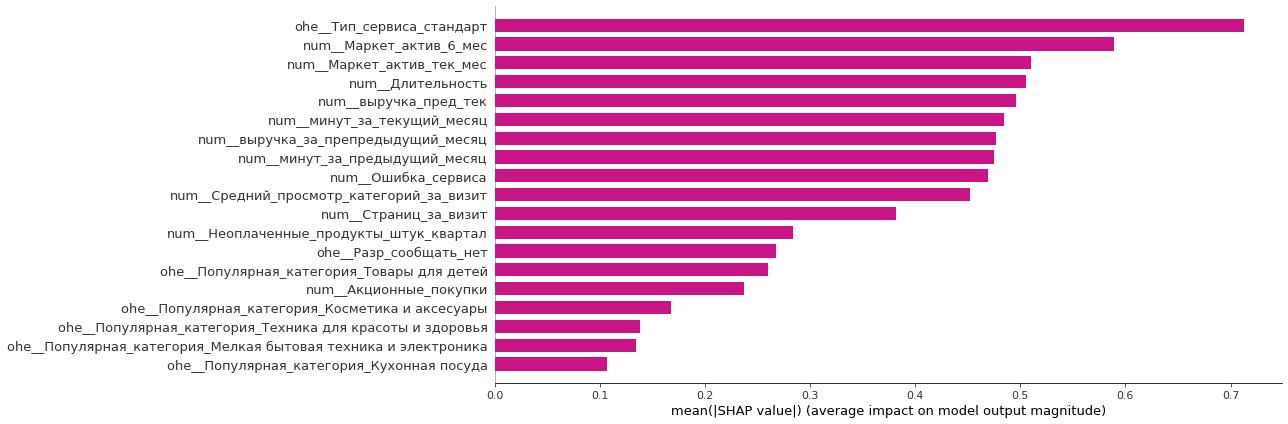

In [79]:
shap_values = grid_1.best_estimator_[:-1].get_feature_names_out()
shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=shap_values , plot_size=(18, 6), color='MediumVioletRed')
plt.show()

По данной гистограмме видно, что наиболее важным признаком является Длительность(значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте). А также в тройку лидеров входит количество минут проведенных на сайте пользователем за предыдущий месяц и среднее значение просмотров категорий за визит сайта пользователем.

Наименее значительными признаками являются популярные категории, самая не популярной оказалась Кухонная посуда.

## Сегментация покупателей

Добавим к данной таблице векроятность того, что покупательская активность снизится.

In [80]:
X_test['снижение_акт'] = y_pred[:, 1]
df = X_test.sort_values(by='снижение_акт')
df.head()

,выручка_за_препредыдущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Тип_сервиса,Разр_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_тек,снижение_акт
424,4934.0,19,16,стандарт,нет,5.0,4,157,0.15,Мелкая бытовая техника и электроника,5,0,5,13,7400.8,0.004463
1059,4465.0,21,23,премиум,да,4.8,3,939,0.11,Домашний текстиль,6,1,7,12,8509.6,0.007174
810,4912.0,16,17,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,7262.2,0.014290
719,4771.0,19,21,премиум,да,3.9,4,379,0.24,Мелкая бытовая техника и электроника,4,1,4,11,7491.9,0.015968
511,5222.0,12,21,стандарт,да,5.8,4,408,0.16,Мелкая бытовая техника и электроника,4,2,3,12,10883.6,0.016887


Построим гистограммы зависимости вероятности снижения активности пользователей от каждого числового столбца.

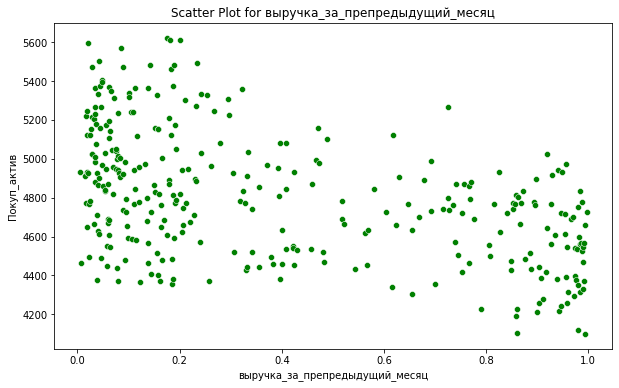

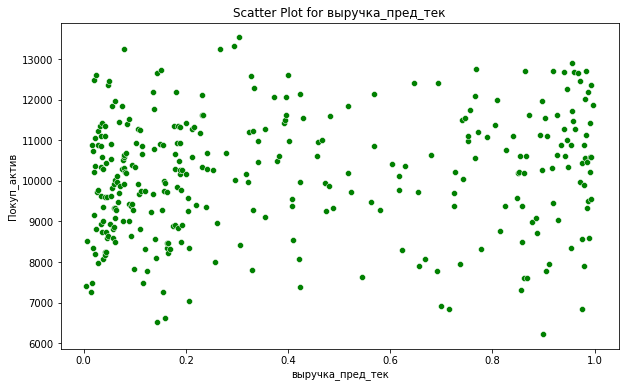

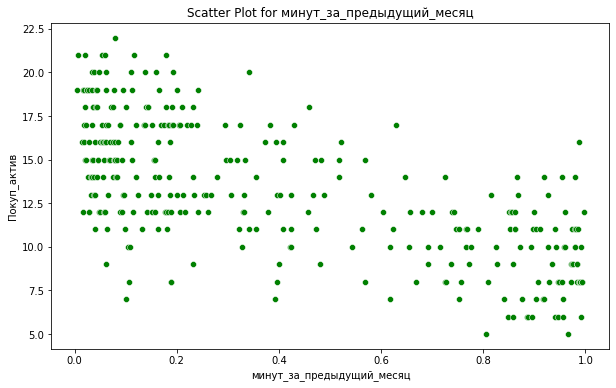

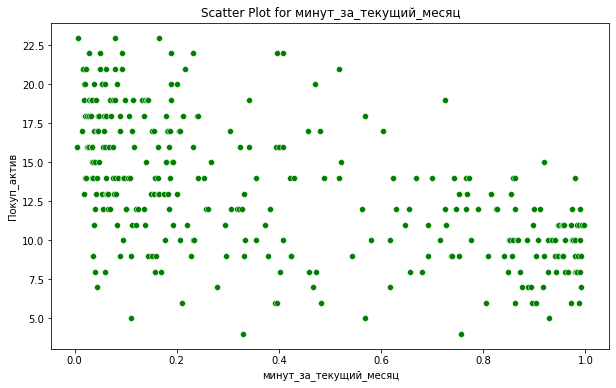

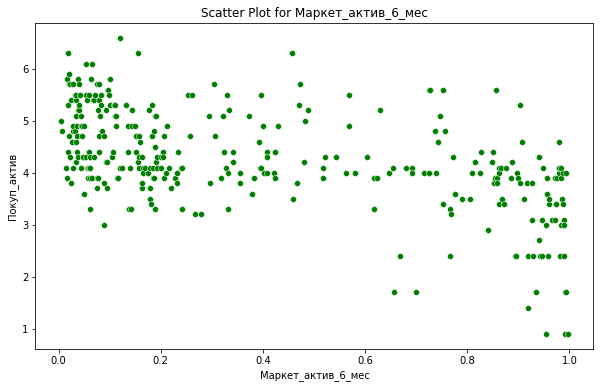

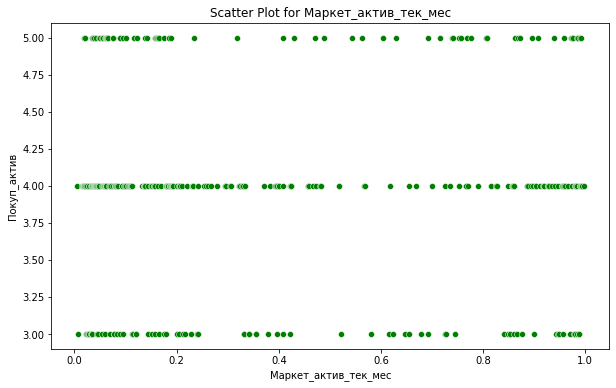

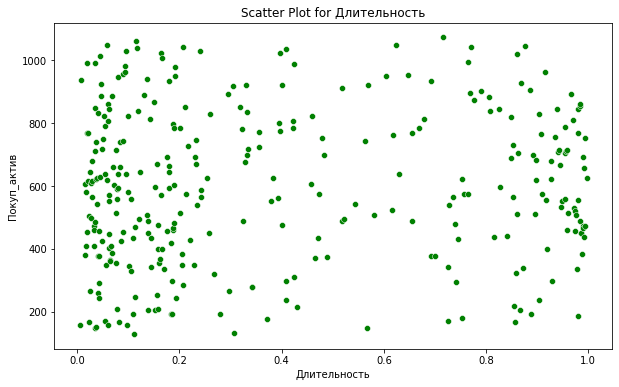

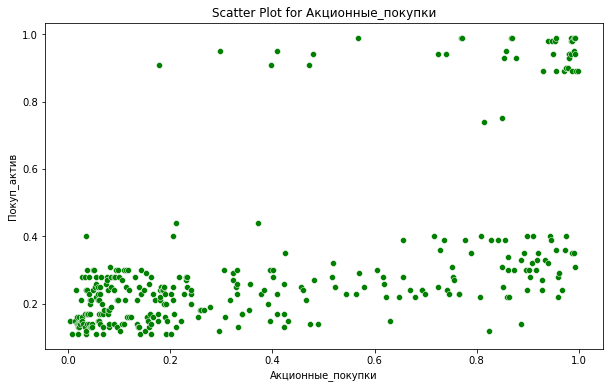

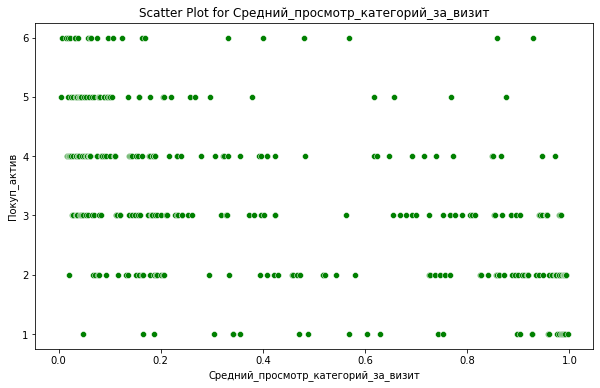

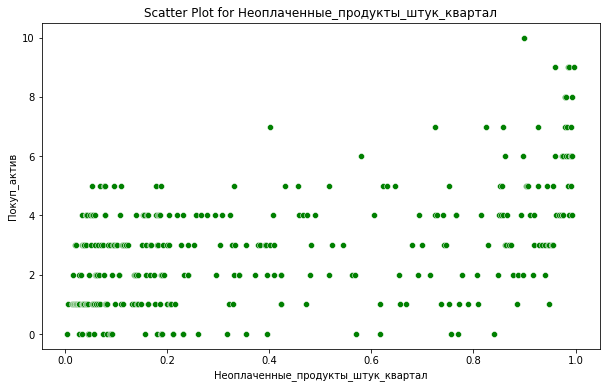

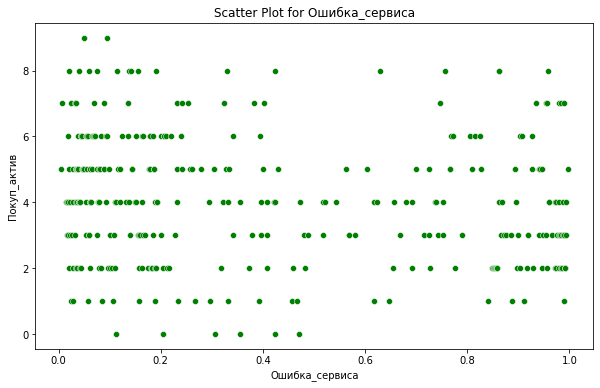

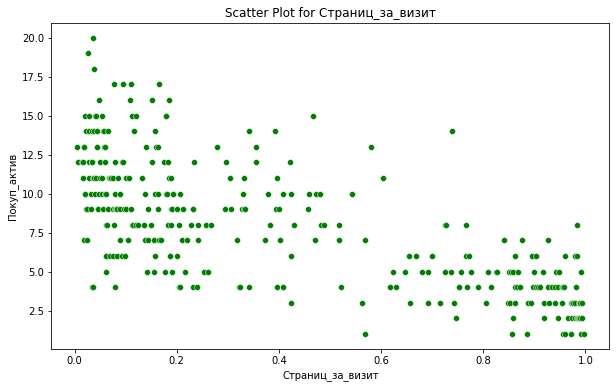

In [81]:
num_col = ['выручка_за_препредыдущий_месяц', 
           'выручка_пред_тек',
           'минут_за_предыдущий_месяц',
           'минут_за_текущий_месяц',
           'Маркет_актив_6_мес',
           'Маркет_актив_тек_мес',
           'Длительность',
           'Акционные_покупки',
           'Средний_просмотр_категорий_за_визит',
           'Неоплаченные_продукты_штук_квартал',
           'Ошибка_сервиса',
           'Страниц_за_визит'] 
for col in num_col:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['снижение_акт'], y=col, data=df, color='Green')
    plt.title(f'Scatter Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Покуп_актив')
    plt.show()

**выручка_за_препредыдущий_месяц**
покупатели со сниженной активностью приносят выручку за препредыдущий месяц менее 5000.

**выручка_пред_тек**
покупатели обоих классов приносят почти одинаковую выручку

**минут_за_предыдущий_месяц**
покупатели со сниженной активностью проводили менее 15 минут на сайте в прошлом месяце

**минут_за_текущий_месяц**
покупатели со сниженной активностью проводили менее 15 минут на сайте в текущем месяце

**Маркет_актив_6_мес**
покупатели со сниженной активностью менее 5 в большинстве случаев

**Маркет_актив_тек_мес**
почти одинаково для обеих групп пользователей

**Длительность**
почти одинаково для обеих групп пользователей

**Акционные_покупки**
более активные пользователи сосредоточены до 0.4, большая часть даже в районе 0.2

**Средний_просмотр_категорий_за_визит**
почти одинаково для обеих групп пользователей

**Неоплаченные_продукты_штук_квартал**
более активные пользователи имели неоплаченные товары в количестве 5 и менее

**Ошибка_сервиса**
почти одинаково для обеих групп пользователей

**Страниц_за_визит**
неактивные пользователи просматривали менее 7.5 страниц за визит

Рассмотрим выручку менее 5000, так как именно столько приносят покупатели со сниженной активностью.

Отдельно выделим пользователей которые приносят выручку менее 5000, то есть неактивных пользователей

In [82]:
revenue_data = df.query('выручка_за_препредыдущий_месяц < 5000')
revenue_data.head()

,выручка_за_препредыдущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Тип_сервиса,Разр_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_тек,снижение_акт
424,4934.0,19,16,стандарт,нет,5.0,4,157,0.15,Мелкая бытовая техника и электроника,5,0,5,13,7400.8,0.004463
1059,4465.0,21,23,премиум,да,4.8,3,939,0.11,Домашний текстиль,6,1,7,12,8509.6,0.007174
810,4912.0,16,17,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,7262.2,0.014290
719,4771.0,19,21,премиум,да,3.9,4,379,0.24,Мелкая бытовая техника и электроника,4,1,4,11,7491.9,0.015968
487,4932.0,17,13,стандарт,нет,6.3,4,582,0.14,Косметика и аксесуары,5,1,6,13,10742.2,0.017767


И построим гистограммы для них.

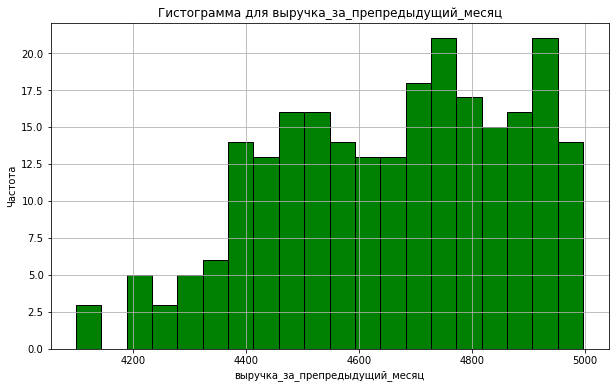

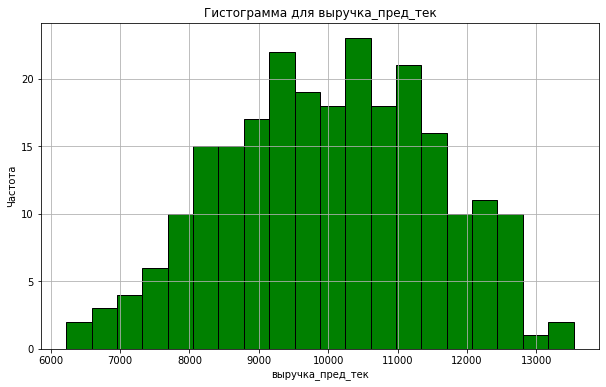

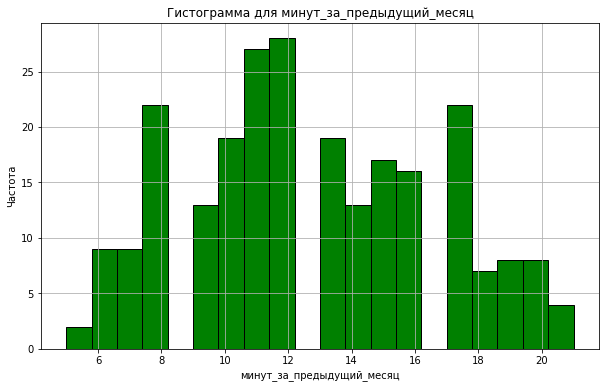

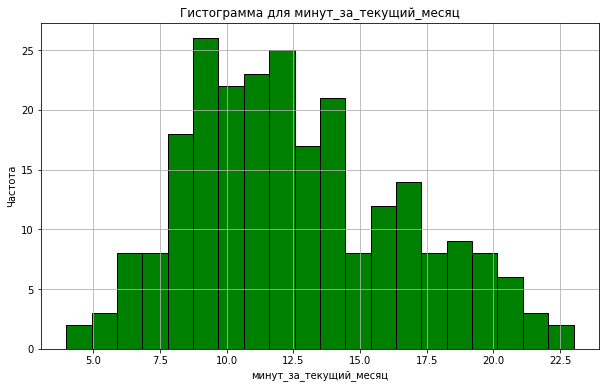

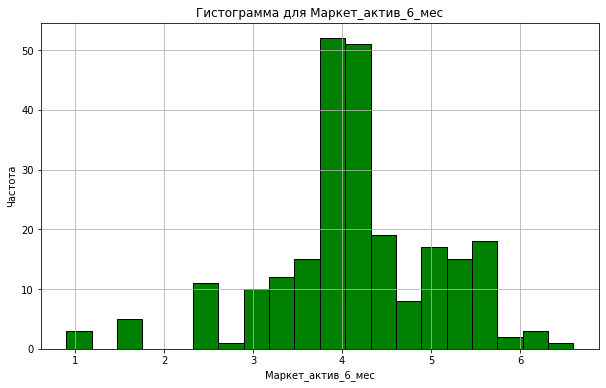

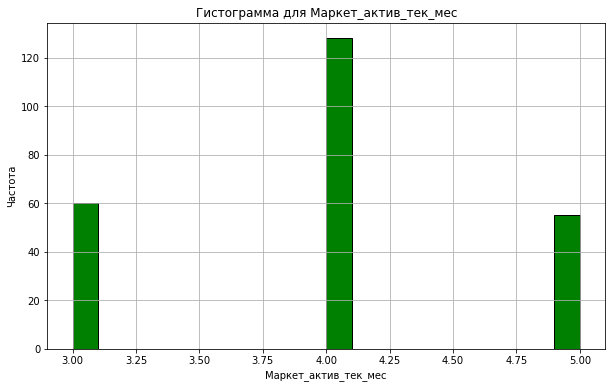

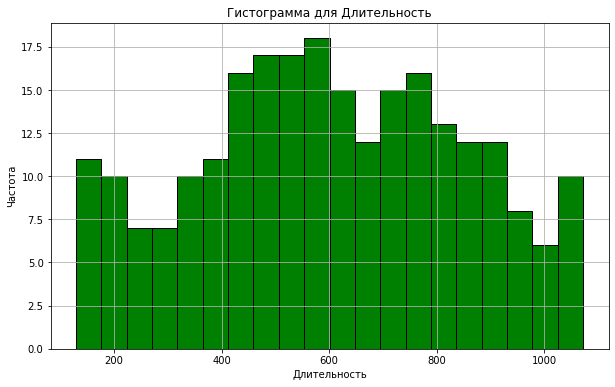

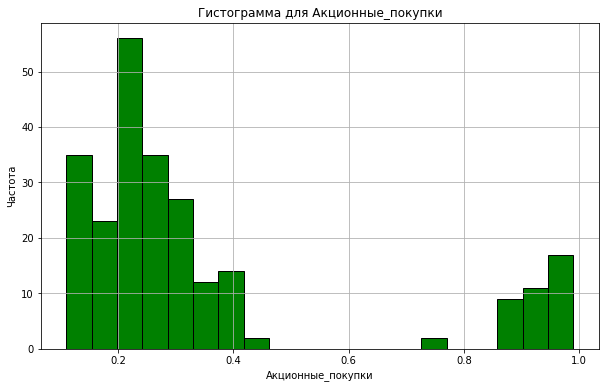

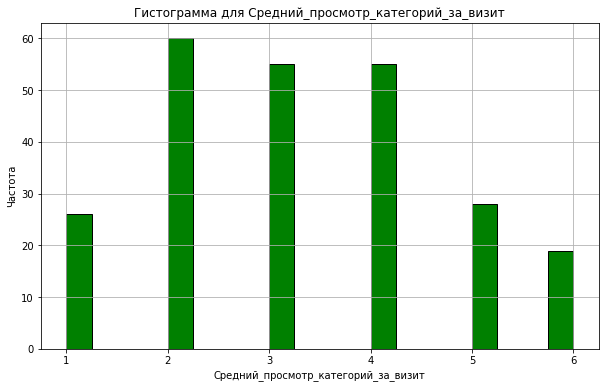

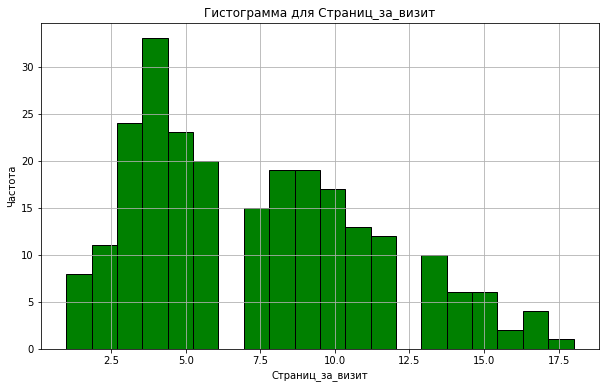

In [83]:
num_cat=['выручка_за_препредыдущий_месяц', 
           'выручка_пред_тек',
           'минут_за_предыдущий_месяц',
           'минут_за_текущий_месяц',
           'Маркет_актив_6_мес',
           'Маркет_актив_тек_мес',
           'Длительность',
           'Акционные_покупки',
           'Средний_просмотр_категорий_за_визит',
           'Страниц_за_визит']

for col in num_cat:
    revenue_data[col].hist(bins=20, figsize=(10, 6), color='green', edgecolor='black')
    plt.title(f'Гистограмма для {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

По гистограммам можно сказать следующее:
выручка за предыдущий и текущий месяцы распределена нормально
количество маркетинговых коммуникаций в текущем месяце делится строго на 3 группы: 3, 4 и 5
длительность нормально распределена
а акционные покупки грубо говоря делятся на 2 группы (0-0.4 и 0.7-1)
максимальное количесьтво просмотренных категорий - 6
количество страниц за визит имеет нормальное распределение и максимум=20

Наиболее четко прослеживается разделение покупателей по акционным покупкам по значению 0.6

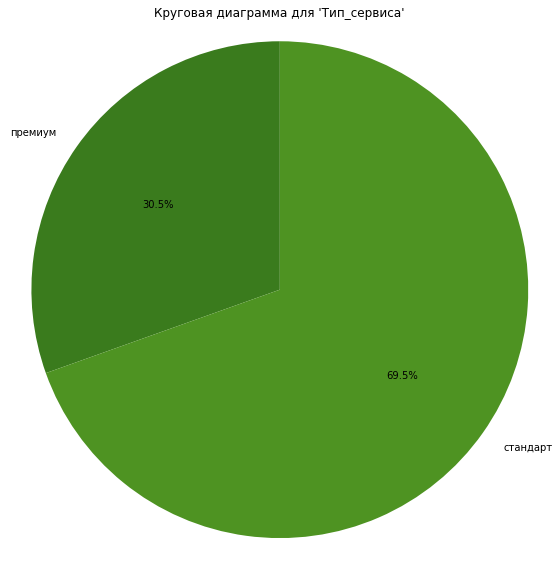

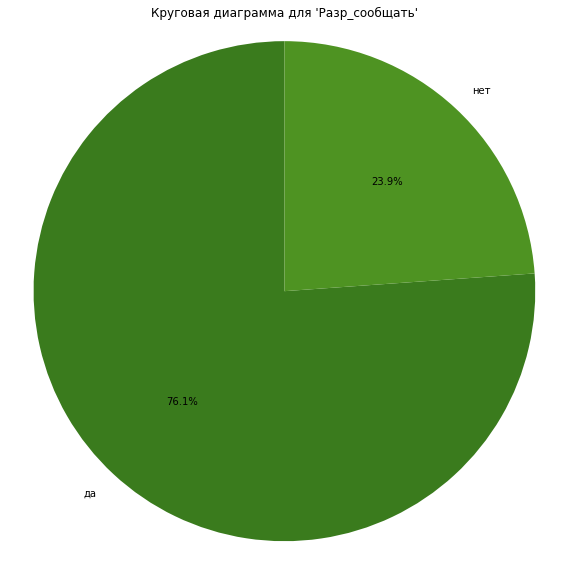

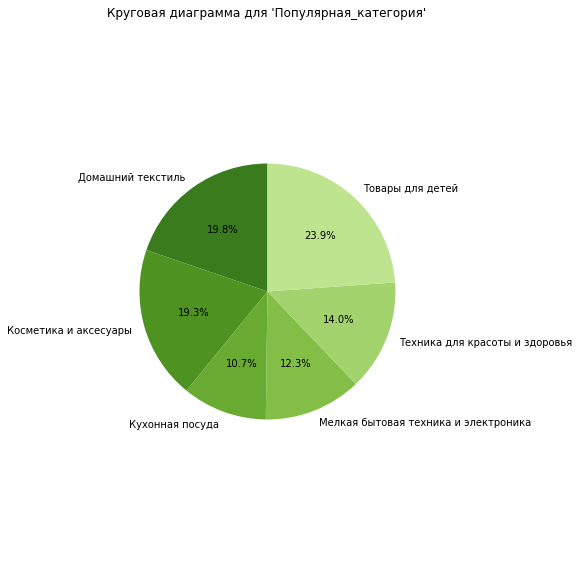

In [84]:
cat_col = ['Тип_сервиса',  
           'Разр_сообщать', 
           'Популярная_категория'] 

palette = sns.color_palette("PiYG_r", len(revenue_data[col].unique()))
for col in cat_col:
    counts = revenue_data[col].value_counts().sort_index()  
    
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, colors=palette, autopct='%1.1f%%', startangle=90)
    plt.title(f"Круговая диаграмма для '{col}'")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

По последней диаграмме видно, что наиболее часто покупаемой категорией являются Товары для детей. Большая часть покупателей пользуется стандартным видом сервиса и разршила присылать им сообщения.

Подводя итог по всем последним графикам можно предложить ввести акции на товары для детей и домашний текстиль, чтобы повыить покупательскую способность, так как данные категории пользуются наибольшим спросом.
Рассмотрим распределение прибыли

Рассмотрим все данные, для этого присоединим таблицу market_final.

In [85]:
market_merge = market_final.merge(money, 
                      on='id', 
                      how='left',)
market_merge.head()

,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Покуп_актив,Тип_сервиса,Разр_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_тек,Прибыль
0,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10187.6,4.16
1,215350,5457.5,4826.0,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,10515.9,3.13
2,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,12768.4,4.87
3,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11680.0,4.21
4,215353,4738.5,5124.0,5388.5,10,10,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10127.0,3.95


In [86]:
market_merge.columns

Index(['id', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц',
       'выручка_за_текущий_месяц', 'минут_за_предыдущий_месяц',
       'минут_за_текущий_месяц', 'Покуп_актив', 'Тип_сервиса', 'Разр_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'выручка_пред_тек', 'Прибыль'],
      dtype='object')

Рассмотрим распределение прибыли относительно частоты покупательской активности.

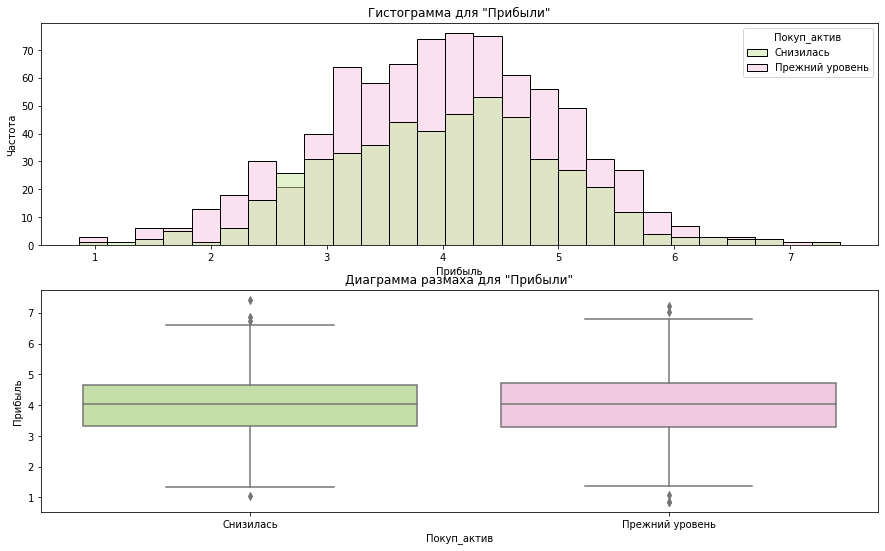

In [87]:
column = market_merge['Прибыль']
plt.figure(figsize=(15,9))
plt.subplot(2, 1, 1)
plt.title(f'Гистограмма для "Прибыли"')
sns.histplot(data=market_merge, x=column, hue='Покуп_актив', palette='PiYG_r')
plt.ylabel('Частота')
    
plt.subplot(2, 1, 2)
plt.title(f'Диаграмма размаха для "Прибыли"')
sns.boxplot(x='Покуп_актив', y=column, data=market_merge, palette='PiYG_r');


Прибыль примерно одинакова для групп пользователей с активной покупательской способностью и нет.

Выделим сегмент по категории товаров и проведем еще один анализ.

In [88]:
m_k = market_merge.query('Популярная_категория == "Товары для детей"')
m_k.head()

,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц,Покуп_актив,Тип_сервиса,Разр_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_тек,Прибыль
0,215349,5216.0,4472.0,4971.6,12,10,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10187.6,4.16
2,215351,6158.0,4793.0,6610.4,11,13,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,12768.4,4.87
3,215352,5807.5,4594.0,5872.5,8,11,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11680.0,4.21
6,215355,3263.0,4749.0,3772.6,12,10,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,7035.6,5.26
12,215363,6010.0,4633.0,6128.3,8,5,Снизилась,стандарт,нет,4.9,4,923,0.29,Товары для детей,6,0,3,1,12138.3,1.83


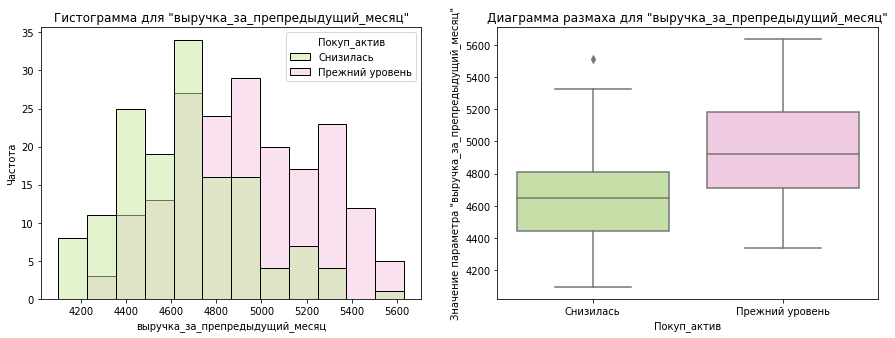

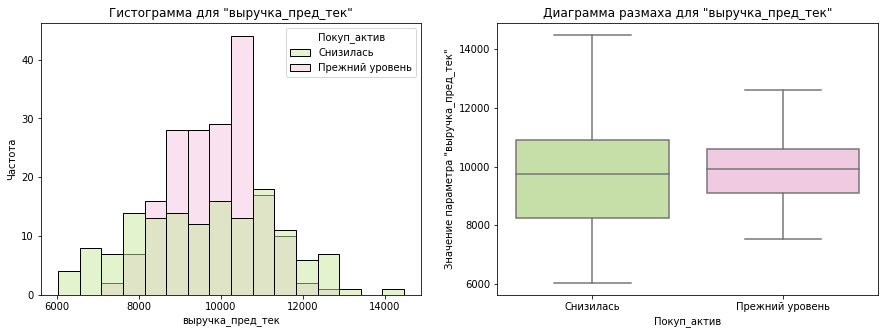

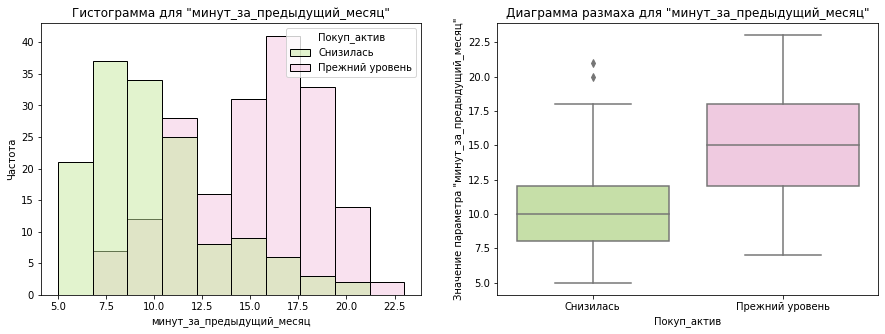

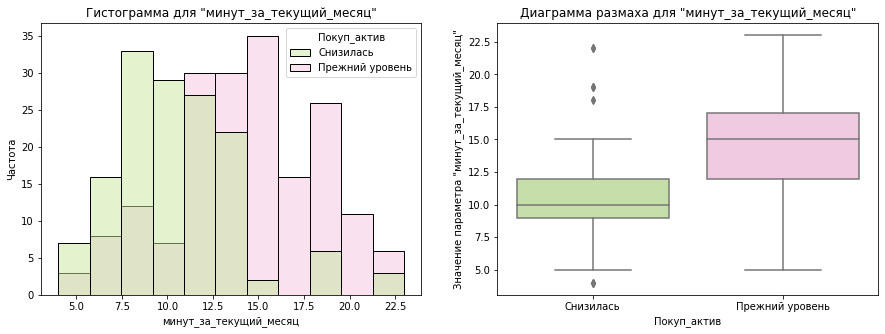

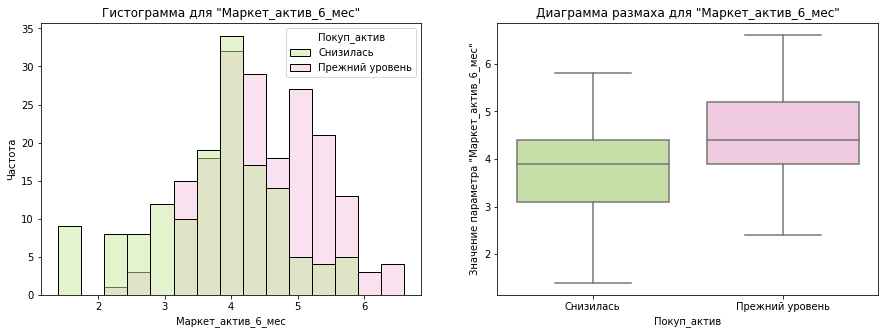

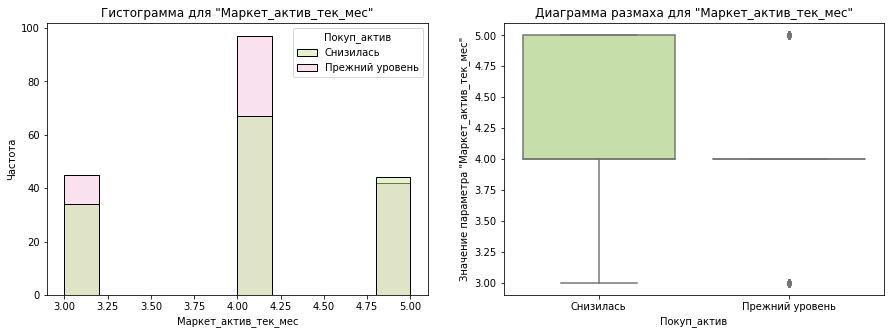

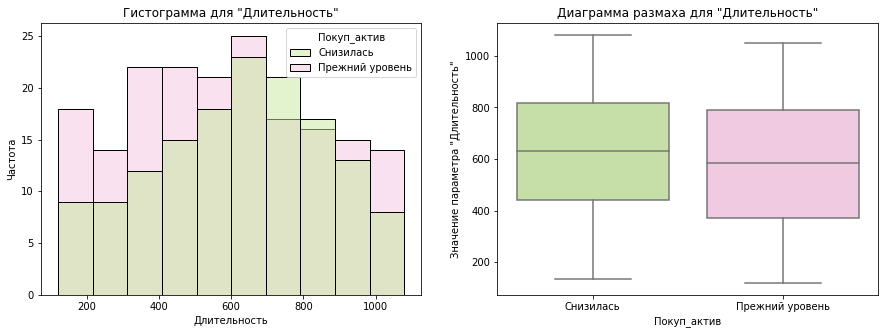

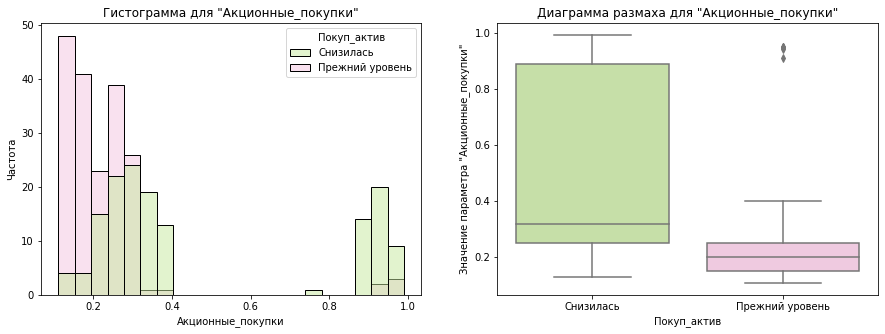

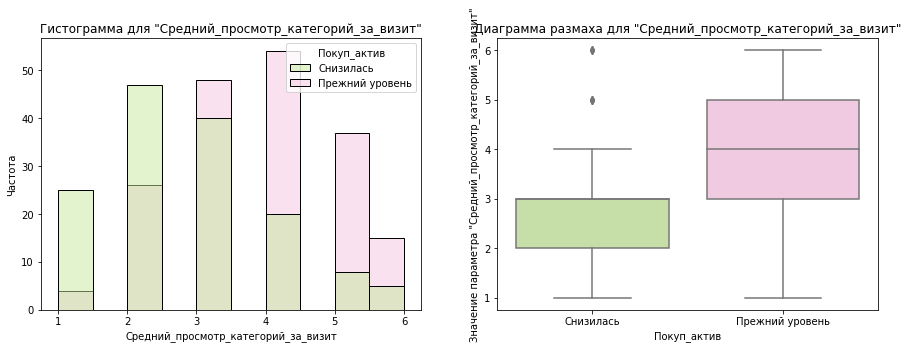

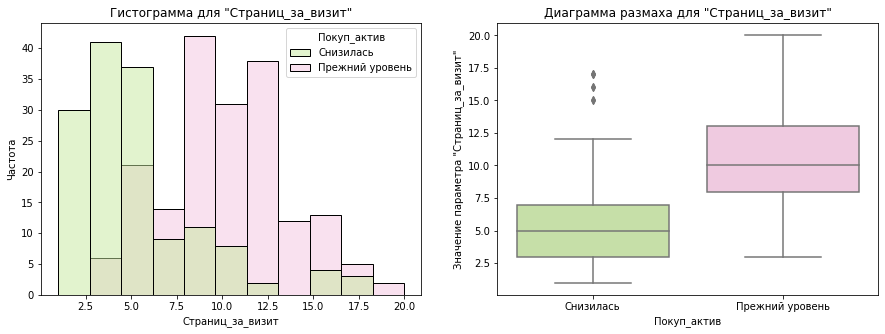

In [89]:
for col in num_cat:
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма для "{col}"')
    sns.histplot(data=m_k, x=col, hue='Покуп_актив', palette='PiYG_r')
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха для "{col}"')
    sns.boxplot(x='Покуп_актив', y=col, data=m_k, palette='PiYG_r');
    plt.ylabel(f'Значение параметра "{col}"')

По данным граыикам можно предложить следующее:
Клиенты, приобретающие товары для детей и испытывающие снижение покупательской активности, в большинстве своем совершают покупки по акциям, редко смотрят другие категории товаров во время визита, просматривают небольшое количество страниц и проводят меньше времени на веб-сайте, чем клиенты с неизменной активностью.

Выручка два месяца назад у клиентов с пониженной активностью была меньше, чем у клиентов с неизменной активностью. Однако в прошлом и текущем месяцах выручка от обеих групп приблизительно одинакова. 

Возможно, стоит организовать специальные акции на детские товары, разместив их на главных страницах сайта, чтобы привлечь внимание этих клиентов.

## Заключение

В рамках проекта был выполнен анализ данных клиентов интернет-магазина "В один клик" с целью предсказания покупательского поведения на ближайшие три месяца.

Были загружены данные, обработы: удалены дубликаты, приведены данные к единому виду, переименованые столбцы в соответствии со стандартом. Далее были построены гисторграммы, отображающие данные.

Далее был создан пайплайн и обучено 4 модели. Среди которых лучшей оказалась модель SVC.

Далее на основе модели был проведен анализ различных категорий и выявилось, что люди со сниженной покупательской активностью приносят прибыль менее 5000.

Отобрав именно такие данные(менее 5000) пришли к выводу, что именно распределение акционных окупок отличается у покупателей со сниженной активностью и с прежней.
Так как в ходе исследования категориальных данных выяснилось, что наиболее часто покупаемой категорией являются детские товары, то во-первых провели исследование для этой категории. Оно показало, что действительно люди со сниженной покупательлской активностью небольшое количество времени проводят на сайте и у них большое количество неоплачяенных товаров. То есть вероятнее всего они откладывают необходимые товары и ждут акции.

Во-вторых на основе все исследований была выдвинута следующая рекомендация: для покупателей со сниженной активностью предложить акции, осообенно на те категории, что пользуются наибольшим спросом - детские товары и домашний текстиль.